# Integrating The mRNA Distribution From Constitutive Expression

(c) 2016 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT) 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 

# The following lines are for rendering plots in this notebook only.
%matplotlib inline
sns.set_context('notebook')

---

In this tutorial, we will expand upon our [numerical integration of the mean mRNA copy number](euler_integration_constitutive_expression.html) by solving for the complete mRNA copy number distribution as a function of time

##  Setting up the model

<div class="alert alert-info">

Include derivation/description of the problem.

</div>

Our equation is

$$
\frac{dP(m,t)}{dt} = rP(m-1,t) + \gamma (m+1)P(m+1, t) - rP(m,t) - \gamma mP(m,t)
$$

where $m$ is the number of mRNAs, $t$ is the timepoint, $r$ is the production rate of mRNA, $\gamma$ is teh degradation rate of mRNA, and $P(m,t)$ is the probability of mRNAs at time $t$. We'll start our integration by first defining a few parameters.

In [2]:
# Define the parameters of our system.
r = 1  # Production rate of mRNA in 1/min.
gamma = 1 / 3  # Degradation rate of mRNA in 1/min
dt = 0.05  # Time step in units of min
time = 10  # Total time of integration in units of min.
num_steps = int(time / dt)  # Total number of time steps.

In the above code, we converted the `num_steps` variable to an integer. This is because Python will evaluate the division as a float but we will take a finite number of steps. We'll be computing the probability of observing a given number of mRNAs per cell. This means for each step, we will have to iterate through all possible mRNA copy numbers and compute the probability given by our differential equation. This means that we will have to set some upper bound for the number of mRNAs possible per cell. You can feel free to change these numbers, but for the purposes of this tutorial, we will set this upper bound as 20 mRNAs per cell. 

In [3]:
upper_bound = 20  # in units of mRNA per cell

We will have to be careful with how we store the probabilities. Rather than storing them in a one-dimensional vector, we will store our probabilities in a two-dimensional array in which each row will represent an mRNA copy number and each column will correspond to a single time step. Let's generate this array and print the output.  

In [4]:
# Construct the two dimensional storage vector.
prob = np.zeros((upper_bound + 1, num_steps))
print(prob)
print(np.shape(prob))

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(21, 200)


Note that we made this array have 21 rows because we have to consider $P(m+1,t)$ in our differential equation. 

Our next step will e setting our initial condition. In this case, we'll start our integration with there being 0 mRNAs in the cell. This means that $P(m=0,t=0) = 1$.

In [5]:
# Set the initial condition.
prob[0,0] = 1

We are now ready to begin our integration. At each time step, we will loop through each possible mRNA copy number and compute its probability. We will construct our integration in a clever way to only add in the term $rP(m-1, t)$ if we have more than 0 mRNAs. 

In [6]:
# Begin the integration.
for t in range(1, int(num_steps)):
    for m in range(upper_bound):
        # Compute P(m, t).
        prob[m, t] = prob[m, t-1] + gamma * dt * prob[m+1, t-1] -\
                     r * dt * prob[m, t-1] - gamma * dt * m * prob[m, t-1]
        # Now include the term if m > 0
        if m > 0:
            prob[m, t] = prob[m, t] + r * dt * prob[m-1, t-1]

Let's look at the distribution of mRNA copy number at the beginning and end of our integration. We'll do this by making a [subplot]() which is several axes arranged into the same figure.

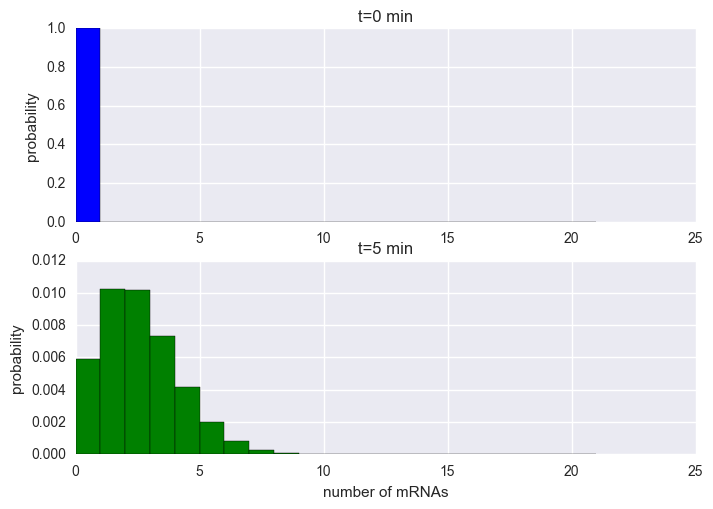

In [7]:
# Make a vector of mRNAs.
mRNA_vec = np.arange(0, upper_bound + 1, 1)

# Make a new figure with two plotting axes.
fig, ax = plt.subplots(2, 1)

# Make a bar plot of the time 0 distribution
ax[0].bar(mRNA_vec, prob[:,0], color='b', width=1)
ax[0].set_ylabel('probability')
ax[0].set_title('t=0 min')
ax[1].bar(mRNA_vec, prob[:,-1], color='g', width=1)
ax[1].set_title('t=5 min')
ax[1].set_ylabel('probability')
ax[1].set_xlabel('number of mRNAs')

We can see that by the end of the integration, the distribution has broaded significantly from our starting condition. It's important to note that we even have some cells that have around fifteen copies of the mRNA! To get a better sense of how the distributions are changing over time, we can make a three-dimensional bar plot. In this case, we'll do essentially the same steps we've done above, except we'll loop over each timepoint and plot the bars. We'll also add a color map so it will be easier to see how it changes with time.

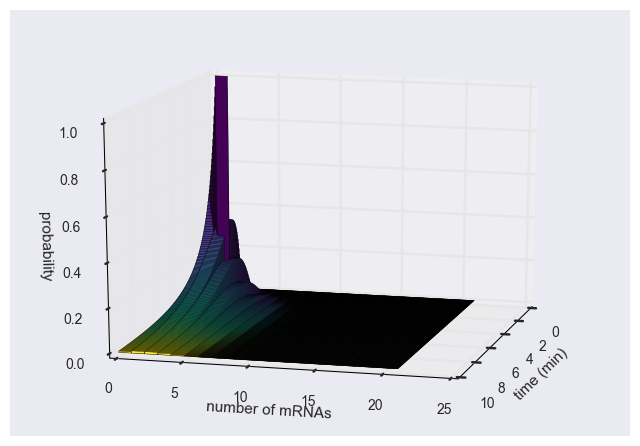

In [8]:
# Set up the plotting figure
fig = plt.figure()

# Add a three-dimensional axis.
ax = fig.add_subplot(111, projection='3d')

# Generate a time vector.
time_vec = np.linspace(0, time, num_steps)

# Set a colormap that will corespond to time. 
colors = sns.color_palette('viridis', n_colors=num_steps)

# Loop through each time step and plot the bar.
for i in range(num_steps):
    ax.bar(mRNA_vec, prob[:,i], time_vec[i], zdir='x', width=1, color=colors[i])
    
# Add axis labels.
ax.set_xlabel('time (min)')
ax.set_ylabel('number of mRNAs')
ax.set_zlabel('probability')

# Rotate the plot for viewing in this notebook.
ax.view_init(15, 15)                 

It's now more obvious to see how it is changing over time as it slowly approaches the steady state.  